# K-NN Classification Practice 
## Using the forest fire data set

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
forest <- read_csv("data_2/forest_fires_cleaned.csv") %>% 
        mutate(Classes = as_factor(Classes)) 
forest

Rows: 244 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): region, Classes
dbl (13): day, month, year, Temperature, RH, Ws, Rain, FFMC, DMC, DC, ISI, B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


region,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Bejaia,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
Bejaia,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire
Bejaia,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sidi-Bel Abbes,28,9,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
Sidi-Bel Abbes,29,9,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire
Sidi-Bel Abbes,30,9,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire


In [5]:
set.seed(1)
forest_split <- initial_split(forest, prop = 0.70, strata = Classes) 
forest_train <- training(forest_split)
forest_test <- testing(forest_split)


In [7]:
# set the seed
set.seed(1) 
# create the recipe  
forest_recipe <- recipe(Classes ~ Rain + FFMC + ISI, data = forest_train) %>% 
                step_scale(all_predictors()) %>% 
                step_center(all_predictors()) 

# create model using tune()
forest_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
            set_engine("kknn") %>% 
            set_mode("classification") 

# create the cross-validation
forest_vfold <- vfold_cv(forest_train, v = 10, strata = Classes) 
gridvals <- tibble(neighbors = seq(1,25)) 

# obtain results using the workflow()
forest_results <- workflow() %>% 
            add_recipe(forest_recipe) %>% 
            add_model(forest_spec) %>% 
            tune_grid(resamples = forest_vfold, grid = gridvals) %>% 
            collect_metrics() %>% 
            filter(.metric == "accuracy") 

forest_results 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9590686,10,0.008968093,Preprocessor1_Model01
2,accuracy,binary,0.9590686,10,0.008968093,Preprocessor1_Model02
3,accuracy,binary,0.9649918,10,0.012963371,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,binary,0.9702206,10,0.01588842,Preprocessor1_Model23
24,accuracy,binary,0.9702206,10,0.01588842,Preprocessor1_Model24
25,accuracy,binary,0.9702206,10,0.01588842,Preprocessor1_Model25


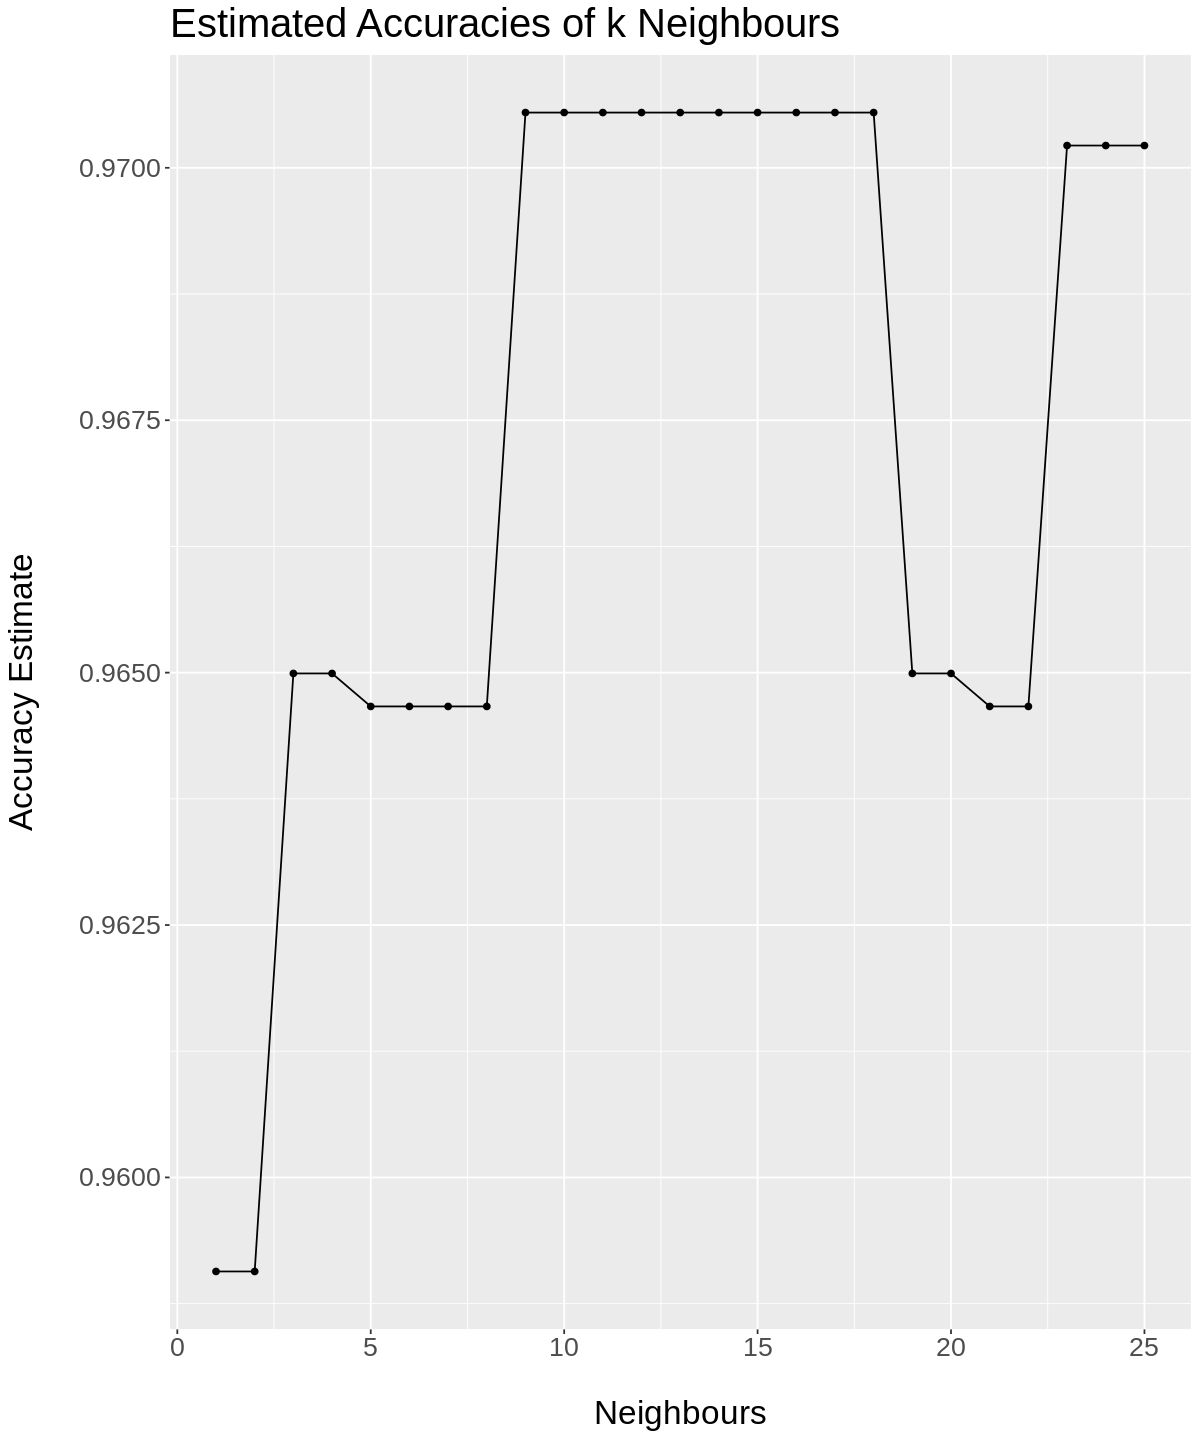

In [15]:
options(repr.plot.width = 10, repr.plot.height = 12) 

ky <- forest_results %>% 
    filter(neighbors == 13) %>% 
    select(mean) %>% 
    pull()

# create plot to see what the optimal k-value to use 

forest_plot <- ggplot(forest_results, aes(x = neighbors, y = mean)) + 
                    geom_point() + 
                    geom_line() + 
                    labs(x = "\nNeighbours",
                         y = "Accuracy Estimate\n",
                         title = "Estimated Accuracies of k Neighbours") +
                    theme(text = element_text(size = 20))
forest_plot

In [17]:
# create a new model with the optimal k-value 
forest_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) %>% 
                    set_engine("kknn") %>% 
                    set_mode("classification") 

forest_fit <- workflow() %>% 
                add_recipe(forest_recipe) %>% 
                add_model(forest_best_spec) %>% 
                fit(data = forest_train) 

forest_predictions <- predict(forest_fit, forest_test) %>% 
                    bind_cols(forest_test) 
forest_predictions              

.pred_class,region,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
not fire,Bejaia,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire
fire,Bejaia,8,6,2012,30,73,15,0.0,86.6,12.1,38.3,5.6,13.5,7.1,fire
not fire,Bejaia,9,6,2012,25,88,13,0.2,52.9,7.9,38.8,0.4,10.5,0.3,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fire,Sidi-Bel Abbes,26,9,2012,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire
not fire,Sidi-Bel Abbes,28,9,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
not fire,Sidi-Bel Abbes,29,9,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire


In [18]:
forest_accuracy <- forest_predictions %>% 
                metrics(truth = Classes, estimate = .pred_class) %>% 
                select(.metric, .estimate) %>% 
                head(1) 
forest_accuracy

.metric,.estimate
<chr>,<dbl>
accuracy,0.972973


In [19]:
forest_conf <- forest_predictions %>% 
                conf_mat(truth = Classes, estimate = .pred_class) 
forest_conf

          Truth
Prediction not fire fire
  not fire       32    2
  fire            0   40